# Deep Learning course homework 2

### Intro:
I decided to train network on old colored movies. I've taked pictures from 4 movies (Operation Y, Courier, Needle, The Diamond Arm) 3891 images in total. The model arcitecture was inspired from here: https://paperswithcode.com/paper/colorful-image-colorization.

The training lasted 160 epochs. 160 epochs.

In [ ]:
# Import of nececcary modules
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import os
from PIL import Image

from kornia.color.lab import rgb_to_lab, lab_to_rgb

In [ ]:
# Own dataset class for model.
class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y, transform):
        self.transform_x = transform_x
        self.transform_y = transform_y
        self.transrofm = transform
    
        filenames = []
        for root, subdirs, files in os.walk(path):
            for file in files:
                        if file.endswith('.jpg') or file.endswith('.JPG') or file.endswith('.png'):
                            filenames.append(os.path.join(root, subdir, file))
            for subdir in subdirs:
                for Root, Dirs, Files in os.walk(os.path.join(path, subdir)):
                    for file in Files:
                        if file.endswith('.jpg') or file.endswith('.JPG') or file.endswith('.png'):
                            filenames.append(os.path.join(root, subdir, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.convert("RGB").copy())
            except:
                pass

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.transrofm(self.images[idx])
        Y = self.transform_y(img)
        X = self.transform_x(img)
        return X, Y

In [ ]:
# Transformations to apply to images.
transform_all = transforms.Compose([
    transforms.RandomResizedCrop(128, ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),

    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor()
])

def get_ab(img): #img in rgb.
    img = rgb_to_lab(img)
    return img[..., 1:,:,:].view(2, 128, 128)

def to_grayscale(img): #img in rgb.
    img = rgb_to_lab(img)
    return img[..., 0, :, :].view(1, 128, 128)

In [ ]:
# Training images are stored in 'films' folder.
dataset = ColorizationDataset('films', to_grayscale, get_ab, transform_all)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

100%|█████████████████████████████████████████████████████████████████████████████| 7782/7782 [00:33<00:00, 231.49it/s]


In [ ]:
len(dataset)

3891

In [ ]:
# Parts of the network.
def Block1(channels_in, channels_out):
    return nn.Sequential(
        nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1, bias=True),
        nn.ReLU(inplace=True),
        nn.Conv2d(channels_out, channels_out, kernel_size=3, stride=2, padding=1, bias=True),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=channels_out)
    )

def Block2(channels_in, channels_out):
    return nn.Sequential(
        nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1, bias=True),
        nn.ReLU(inplace=True),
        nn.Conv2d(channels_out, channels_out, kernel_size=3, stride=1, padding=1, bias=True),
        nn.ReLU(inplace=True),
        nn.Conv2d(channels_out, channels_out, kernel_size=3, stride=2, padding=1, bias=True),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=channels_out)
    )

def Block3(channels_in, channels_out):
    return nn.Sequential(
        nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1, bias=True),
        nn.ReLU(inplace=True),
        nn.Conv2d(channels_out, channels_out, kernel_size=3, stride=1, padding=1, bias=True),
        nn.ReLU(inplace=True),
        nn.Conv2d(channels_out, channels_out, kernel_size=3, stride=1, padding=1, bias=True),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=channels_out)
    )

def Block4(channels_in, channels_out):
    return nn.Sequential(
        nn.Conv2d(channels_in, channels_out, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),
        nn.ReLU(inplace=True),
        nn.Conv2d(channels_out, channels_out, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),
        nn.ReLU(inplace=True),
        nn.Conv2d(channels_out, channels_out, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=channels_out)
    )

def Block5(channels_in, channels_out):
    return nn.Sequential(
        nn.ConvTranspose2d(channels_in, channels_out, kernel_size=4, stride=2, padding=1, bias=True),
        nn.ReLU(inplace=True),
        nn.Conv2d(channels_out, channels_out, kernel_size=3, stride=1, padding=1, bias=True),
        nn.ReLU(inplace=True),
        nn.Conv2d(channels_out, channels_out, kernel_size=3, stride=1, padding=1, bias=True),
        nn.ReLU(inplace=True)
    )

def Block6(channels_in, channels_out):
    return nn.Sequential(
        nn.Conv2d(channels_in, 313, kernel_size=1, stride=1, padding=0, bias=True),
        nn.Softmax(dim=1),
        nn.Conv2d(313, channels_out, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
    )

In [ ]:
# The model
class Colorizer(nn.Module):
    def normalize_L(self, l):
        return (l - 50) / 100
    
    def normalize_ab(self, ab):
        return ab/110
    
    def unnormalize_L(self, l):
        return l*100 + 50
    
    def unnormalize_ab(self, ab):
        return ab*110
    
    def __init__(self):
        super().__init__()
        
        
        self.preupsample = nn.Sequential(
            Block1(1, 64),
            
            Block1(64, 128),
            
            Block2(128, 256),
            
            Block3(256, 512),
            
            Block4(512, 512),
            
            Block4(512, 512),
            
            Block3(512, 512),
            
            Block5(512, 256),
            
            Block6(256, 2)   
        )
    
    def forward(self, L):
        h = self.preupsample(self.normalize_L(L))
        h = nn.Upsample(scale_factor=4, mode="bilinear")(h)
        return self.unnormalize_ab(h)

In [ ]:
device = "cuda:0"

## Trainig the network.

There is no training output since it was cleared after the restart of the notebook and I don't want to start it again

In [ ]:
num_epochs = 50
lr = 1e-3

In [ ]:
model = Colorizer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.L1Loss()  # тут можно поиграться с лоссами

In [ ]:
history = []
for epoch in range(num_epochs):
    for x, y in loader:
        # 0. Place data on the device
        x = x.to(device)
        y = y.to(device)
        
        # 1. Reset gradient
        optimizer.zero_grad()
        
        # 2. Make prediction
        pred = model(x)
        
        # 3. Loss calculation
        loss = criterion(pred, y)
        
        # 4. Put loss into the array
        history.append(loss.item())
        
        
        # 5. Back propogate errors
        loss.backward()
        
        # 6. Bake a step
        optimizer.step()
        
        del x
        del y
        torch.cuda.empty_cache()

    print(epoch, history[-1])

In [ ]:
del x
del y
torch.cuda.empty_cache()

In [ ]:
torch.save(model, "3and1movies160epochs.colorizer")

## Results.

### Code for printing

In [ ]:
model = torch.load("3and1movies160epochs.colorizer").to(device)

In [ ]:
# 'test' folder consists from bnw images from some movie.
testset = ColorizationDataset('test', to_grayscale, get_ab, test_transform)

In [ ]:
def to_numpy_image(img):
    img = lab_to_rgb(img)
    return img.detach().cpu().view(3, 128, 128).transpose(0, 1).transpose(1, 2).numpy()

In [ ]:
arr = [2957, 2984]
for t in np.random.randint(0, len(dataset), 100):
    img_L, img_ab = dataset[t]
    img_gray = img_L
    pred_ab = model(img_L.to(device).view(1, 1, 128, 128)).detach().clone().cpu()
    img_pred = torch.stack([img_gray, pred_ab[...,0,:,:], pred_ab[...,1,:,:]], dim=-3)
    img_pred = to_numpy_image(img_pred)
    # теперь это numpy-евский ndarray размера (128, 128, 3)
    plt.figure(figsize=(12,12))
    
    plt.subplot(141)
    plt.axis('off')
    plt.set_cmap('Greys')
    plt.imshow(img_L.reshape((128, 128)))

    plt.subplot(142)
    plt.axis('off')
    plt.imshow(img_pred.reshape((128, 128, 3)))

    plt.subplot(143)
    plt.axis('off')
    plt.imshow(to_numpy_image(torch.stack([img_gray, img_ab[...,0,:,:].view(1,128,128), img_ab[...,1,:,:].view(1,128,128)], dim=-3)))
    
    print(t)
    plt.show()

### Results on training set:

Since training set contains a lot of people, model trained to paint the people relatively good:

Images are: input image, predicted image, original image respectively

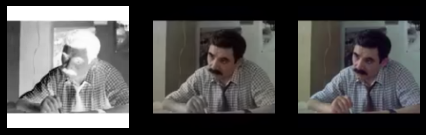

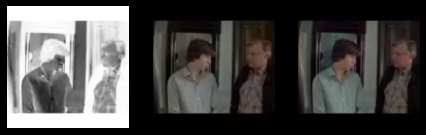

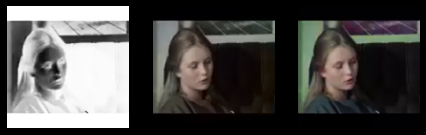

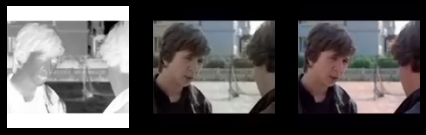

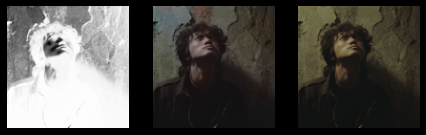

As we can see, it has problems with colorizing background and clothes. Interesting thing is that on the last image model added cold tones, although it tends to turn yellow (which will be seen later)

Images that shows **errors** of the model:
Images are: input image, predicted image, original image respectively

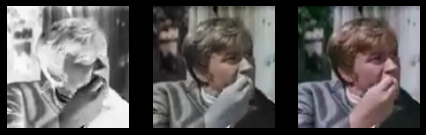

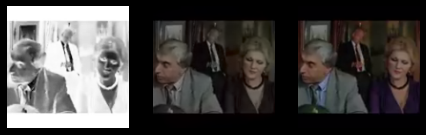

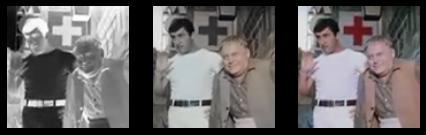

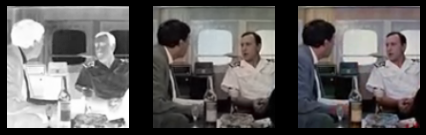

The model sometimes don't recognizes human limbs (first images). Don't pay attention to all people on the image (second example) and has problems coloring common objects such as clothing. Don't know how to paint red X (Not so much images in training set)

**Interesting pictures produced by the model**

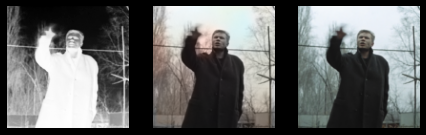

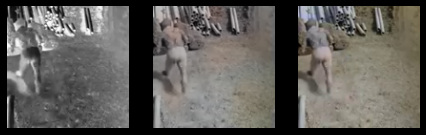

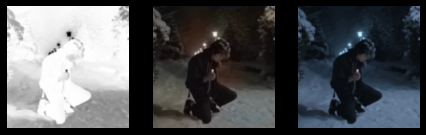

From images 1 and 3 we can conclude that model prefers warm tones. On the second image model hasn't recognized cement on the body, but it recognized human body and painded it.

### Results on unknown images

As was mentioned earlier, model is qute good in painting people:

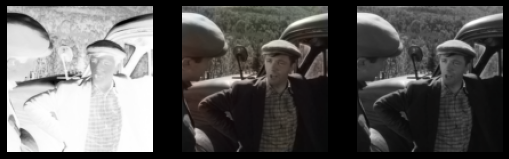

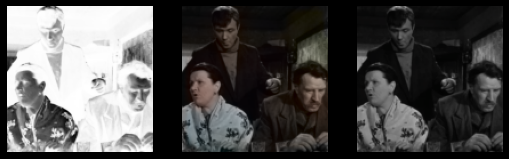

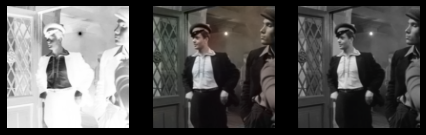

We have no original image to compare with but on the example pictures model has colorized background quite realistically

**Errors of the model**

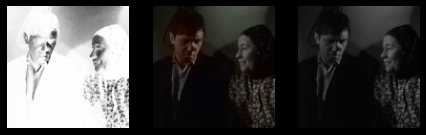

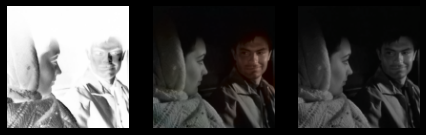

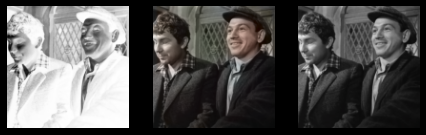

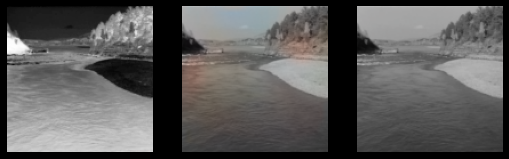


The same problem as on the training set (who would have thought) model sometimes forgets about another person.

The last image was painted wront since there was no (or too little) images of the nature in the training set.